### Урок 6. Градиентный бустинг (AdaBoost)

1. Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.
2. Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

#### Подготовительная часть

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Boosting:
    def __init__(self, *, max_depth=1, eta=0.1, random_state=42, n_estimators=3):
        """
        Конструктор.
        :param max_depth: Максимальная глубина дерева
        :param eta: Скорость обучения
        :param random_state:
        :param n_estimators: Количество деревьев
        """
        self.trees = []
        self._max_depth = max_depth
        self._eta = eta
        self._random_state = random_state
        self._n_estimators = n_estimators

        self._train_errors = []
        self._test_errors = []


    def fit(self, X_train, y_train, X_test, y_test):
        """
        Обучение модели.
        :param X_train: Фичи (трэин)
        :param y_train: Таргет (трэин)
        :param X_test: Фичи (тест)
        :param y_test: Таргет (тест)
        :return:
        """
        for i in range(self._n_estimators):
            current_tree = DecisionTreeRegressor(max_depth=self._max_depth, random_state=self._random_state)
            target = self._target(X_train, y_train)
            current_tree.fit(X_train, target)
            self.trees.append(current_tree)

            self._train_errors.append(
                self._mse(y_train, self.predict(X_train))
            )
            self._test_errors.append(
                self._mse(y_test, self.predict(X_test))
            )

    def predict(self, rows):
        """Предсказание."""
        return np.array(sum([tree.predict(rows)*self._eta for tree in self.trees]))

    def _target(self, rows, y):
        """Получение значений целевой переменной."""
        if len(self.trees) == 0:
            return y
        return self._residual(y, self.predict(rows))


    def _residual(self, y:float, z:float) -> float:
        return - (z - y)

    def _mse(self, real, predicted) -> float:
        """Получение ошибки."""
        return sum((real-predicted)**2)/ len(real)

    def get_train_errors(self):
        return self._train_errors

    def get_test_errors(self):
        return self._test_errors


    def get_test_mse(self):
        return self._test_errors[-1] if len(self._train_errors) else 0

    def get_train_mse(self):
        return self._train_errors[-1] if len(self._train_errors) else 0


---

#### Практическая часть
##### Для реализованной модели градиентного бустинга постройте графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделайте выводы о зависимости ошибки от этих параметров.

In [3]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Проверим влияние глубины деревва, при количестве деревьев равном 10 и скорости обучнеия 0.1

Минимальная ошибка: 5992.360741839059 при глубине равной 4


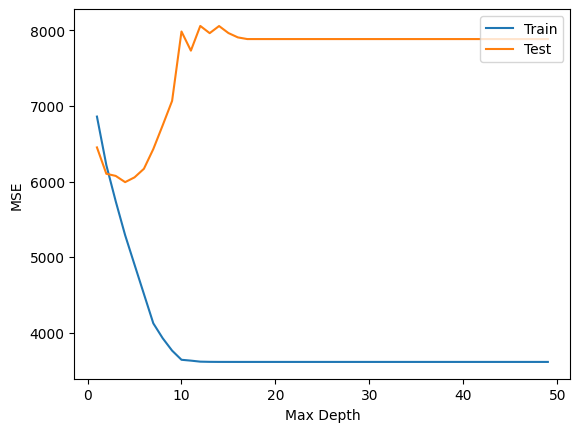

In [4]:
train_errs = []
test_errs = []
depth_list = range(1, 50)
for max_depth in depth_list:
    model = Boosting(max_depth=max_depth, eta=0.1, n_estimators=10)
    model.fit(X_train, y_train, X_test, y_test)
    train_errs.append(model.get_train_mse())
    test_errs.append(model.get_test_mse())

print(f'Минимальная ошибка: {min(test_errs)} при глубине равной {test_errs.index(min(test_errs))+1}')

# Построение графика
plt.plot(depth_list, train_errs, label='Train')
plt.plot(depth_list, test_errs, label='Test')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.legend(loc='upper right')

Проверим влияние количества деревьев, при максимальной глубине 4 и скорости обучнеия 0.1

Минимальная ошибка: 3459.2898706185256 при количестве деревьев 25


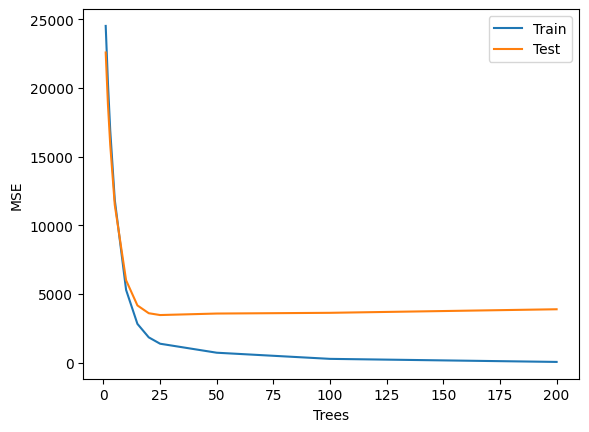

In [5]:
train_errs = []
test_errs = []
n_trees = [1, 2, 3, 5, 10, 15, 20, 25, 50, 100, 200]
max_depth = 4
for n in n_trees:
    model = Boosting(max_depth=max_depth, eta=0.1, n_estimators=n)
    model.fit(X_train, y_train, X_test, y_test)
    train_errs.append(model.get_train_mse())
    test_errs.append(model.get_test_mse())

print(f'Минимальная ошибка: {min(test_errs)} при количестве деревьев {n_trees[test_errs.index(min(test_errs))]}')

# Построение графика
plt.plot(n_trees, train_errs, label='Train')
plt.plot(n_trees, test_errs, label='Test')
plt.xlabel('Trees')
plt.ylabel('MSE')
plt.legend(loc='upper right')

#### Вывод
При увеличении максимальной глубины возникает сильное переобучение, ошибка на треине уменьшается, а на тесте растёт.
Тоже самое с увеличением количества деревьев, переобучение возникает после определенного момента.

---

##### Модифицируйте реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки примите равным 0.5. Сравните на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [19]:
class SthBoosting(Boosting):
    def fit(self, X_train, y_train, X_test, y_test):
        """
        Обучение модели.
        :param X_train: Фичи (трэин)
        :param y_train: Таргет (трэин)
        :param X_test: Фичи (тест)
        :param y_test: Таргет (тест)
        :return:
        """
        n_samples = X_train.shape[0]
        n_half_samples = n_samples//2


        for i in range(self._n_estimators):
            current_tree = DecisionTreeRegressor(max_depth=self._max_depth, random_state=self._random_state)
            # получение случайных индексов которые будем использовать
            rnd_idx = np.random.permutation(n_samples)[:n_half_samples]

            target = self._target(X_train[rnd_idx], y_train[rnd_idx])
            current_tree.fit(X_train[rnd_idx], target)
            self.trees.append(current_tree)

            self._train_errors.append(
                self._mse(y_train, self.predict(X_train))
            )
            self._test_errors.append(
                self._mse(y_test, self.predict(X_test))
            )


In [23]:
n_trees = 100
max_depth = 4

In [24]:
# Обучение модели стохастического бустинга
sth_model = SthBoosting(max_depth=max_depth, eta=0.1, n_estimators=n_trees)
sth_model.fit(X_train, y_train, X_test, y_test)

In [26]:
base_model = Boosting(max_depth=max_depth, eta=0.1, n_estimators=n_trees)
base_model.fit(X_train, y_train, X_test, y_test)

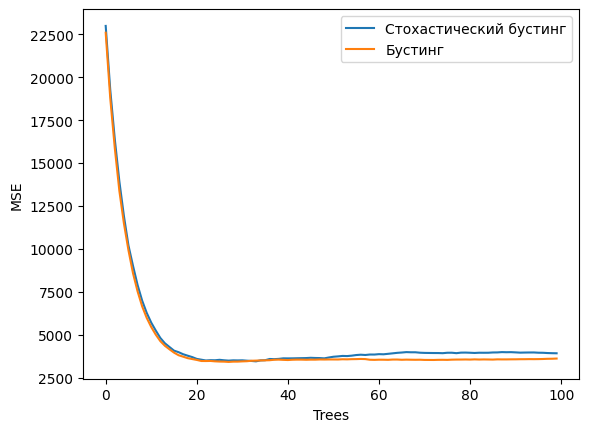

In [27]:
plt.plot(range(n_trees), sth_model.get_test_errors(), label='Стохастический бустинг')
plt.plot(range(n_trees), base_model.get_test_errors(), label='Бустинг')
plt.xlabel('Trees')
plt.ylabel('MSE')
plt.legend(loc='upper right')

Как видно идут почти вровень, но стохастический бустинг более ломаный